#Lab 6: Training neural networks (part 2/2)
**Like always, remember to set Runtime environment to GPU**

In this second part of lab 6 we will explore more tools that will help you train your own neural networks. This time we will be using convolutional neural networks (CNNs). 


##1. Download the CIFAR 10 dataset
We will be using the CIFAR 10 dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

mean = 0.5
std = 0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean, mean, mean), (std, std, std))])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Display some stats

num_train 49984
num_test 9984
images.shape torch.Size([64, 3, 32, 32])


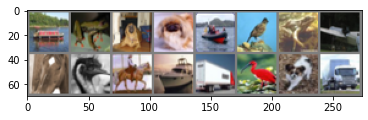

 ship  frog   dog   dog  ship  bird  frog plane horse  bird horse  ship truck  bird   dog truck


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy() / 2 + 0.5 # Un-normalize
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Number of samples
num_train = bs * len(trainloader)
num_test = bs * len(testloader)
print('num_train',num_train)
print('num_test',num_test)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('images.shape',images.shape)

# show 16 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## 2. Task 1 (optional): Setting up your CNN
**You can skip this task and jump directly to Task 2, if you feel comfortable with PyTorch and the different layer types used in CNNs.**

Here, we will set up our own CNN. For this purpose we will need the following layer types:

- [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear])

as well as the reshape operation (called `view` in PyTorch):

- [view](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view)

See complete overview of the basic building block for graphs [here](https://pytorch.org/docs/stable/nn.html).

Let's see how each of these work:

In [4]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

**Side-note:** What's the difference between torch.nn and torch.nn.functional? Read [here](https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597/7)

###2.1 Conv2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

In [5]:
# Print shape of input
print('Input dimensions are (batch_size, channels, height, width)')
print('images.shape',images.shape)

# Perform convolution
conv = nn.Conv2d(3, 6, 5)
x = conv(images)

# Print shape of output
print('x.shape',x.shape)

# Print parameter shapes
for name, param in conv.named_parameters(): print('parameter',name,param.shape)

Input dimensions are (batch_size, channels, height, width)
images.shape torch.Size([64, 3, 32, 32])
x.shape torch.Size([64, 6, 28, 28])
parameter weight torch.Size([6, 3, 5, 5])
parameter bias torch.Size([6])


####2.1.1 Questions
1. What do each of the parameters (3, 6, 5) mean?
2. Recall the formula to calculate the output size of a convolution: 

 `output_size = (input_size - kernel_size) / stride + 1`

 or as defined in the slides of Lecture 5:

 `output_size = (N - W) / stride + 1`

 Is this formula satisfied in the above example?
3. How could you make the output (x) have the same width and height as the input (images)? (Think "padding"...)
4. If the convolution operation performed above was a layer in a CNN, what would the number of parameters of that layer be?

####2.1.2 Answers
1. `(in_channels, out_channels, kernel_size) = (3, 6, 5)`, where `in_channels` is the number of channels of the input (3 here because input is a color image), `out_channels` is the number of feature meaps that will be generated, and `kernel_size` is the filter size. It is common practise to use the names of the arguments, like this:

 `conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)`
2. Yes. We have `N = input_size = 32`, `W = kernel_size = 5`, `stride = 1` (default), so theoretically `output_size = (32-5)/1 + 1 = 28`, which matches the shape of `x`.
3. `Conv2d` has a padding option. By setting `padding = 2`, the output gets the same width/height as the input (see code below). The formula for calculating the right padding size is (see slides from lecture 5): `padding = (W-1)/2 = (5-1)/4 = 2`.
4. For the filter weights the number of parameters is `out_channels * in_channels * kernel_size^2 = 6 * 3 * 5 * 5 = 450`. In addition there is one bias parameters for each output, totalling `450 + 6 = 456` parameters.

In [7]:
# Code for question 2: Padding
conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
x = conv(images)

# Width and height are the same
print('x.shape',x.shape)
print('images.shape',images.shape)

x.shape torch.Size([64, 6, 32, 32])
images.shape torch.Size([64, 3, 32, 32])


###2.2 MaxPool2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d

In [16]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)

# Perform max pool
pool = nn.MaxPool2d(2, 2)
y = pool(x)
print('y.shape',y.shape)

# Print some elements
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])
print('y[0,0,0:2,0:2]:\n',y[0,0,0:2,0:2])

y.shape torch.Size([64, 6, 14, 14])
x[0,0,0:4,0:4]:
 tensor([[ 0.9093,  0.2117,  0.1733, -1.0569],
        [ 0.4325,  2.1304,  0.3696, -1.5292],
        [-0.8045,  1.1758,  1.1639, -0.3028],
        [-1.0955, -1.1652,  0.8811,  1.1676]])
y[0,0,0:2,0:2]:
 tensor([[2.1304, 0.3696],
        [1.1758, 1.1676]])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


####2.2.1 Questions
1. What does MaxPool2d do? (Explain the output `y[0,0,0:2,0:2]` and compare to `x[0,0,0:2,0:2]`)
2. What do each of the parameters (2, 2) mean?

####2.2.2 Answers
1. It downscales the input along the widht and height dimensions. It does so by running a "window" over the input. For each window it outputs the maximum value within the window. In the example above, the window size is 2x2, and the window is shifted to pixels. Hence, the output `y` is half the width/height of the input `x`, and the output values are the maxima of the corresponding window of the input.
2. The first parameter is the window size (or kernel_size), and the second parameter is the stride (i.e., how many pixel the window position is shifted).

###2.3 BatchNorm2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d

In [17]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)*10 + 2
print('x.mean',x.mean())
print('x.std',x.std())

# Perform batch normalization
bn = nn.BatchNorm2d(6)
y = bn(x)
print('y.mean',y.mean())
print('y.std',y.std())

# Print parameter shapes
for name, param in bn.named_parameters(): print('parameter',name,param.shape)

x.mean tensor(2.0013)
x.std tensor(9.9785)
y.mean tensor(5.3725e-09, grad_fn=<MeanBackward0>)
y.std tensor(1.0000, grad_fn=<StdBackward>)
parameter weight torch.Size([6])
parameter bias torch.Size([6])


####2.3.1 Questions
1. What does BacthNorm2D do?
2. What does the input parameter (6) mean?
3. Is the mean and standard deviation after batch normalization as expected?
4. How many parameters does BatchNorm2D have? Why?

####2.3.2 Answers
1. For each batch, it normalizes the values of the input according to the equation found in the documentation (and slides of lecture 6). The normalization is based on a standard score `y=(x-mean(x))/std(x)`, with the addition of two *learnable* parameters that can revert the standard score to produce the identity function if necessary. So the final equation becomes `y = gamma*(x-mean(x))/std(x) + beta` and with `gamma=std(x)` and `beta=mean(x)`, we get the identity function `y=x`. The initial values of the parameters are `gamma=1` and `beta=0`. 
2. It is `num_features` corresponding to `C` with an expected input of size `(N, C, H, W)`.
3. The mean and standard deviation of output `y` should be 0 and 1, respectively. That seems to be the case.
4. It has 2x6: a gamma and a beta for each input channel.

###2.4 ReLU
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU

In [18]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)
print('x.min',x.min())
print('x.max',x.max())
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])

# Apply ReLU
y = F.relu(x)
print('y.min',y.min())
print('y.max',y.max())
print('y[0,0,0:4,0:4]:\n',y[0,0,0:4,0:4])

x.min tensor(-4.4253)
x.max tensor(4.4832)
x[0,0,0:4,0:4]:
 tensor([[-0.3437,  1.7807, -0.4698, -1.8142],
        [-0.5142,  0.6599,  0.2037, -0.3550],
        [-0.9420,  1.5948, -0.6047,  0.4396],
        [ 0.5077, -0.1577,  0.7724, -1.0741]])
y.min tensor(0.)
y.max tensor(4.4832)
y[0,0,0:4,0:4]:
 tensor([[0.0000, 1.7807, 0.0000, 0.0000],
        [0.0000, 0.6599, 0.2037, 0.0000],
        [0.0000, 1.5948, 0.0000, 0.4396],
        [0.5077, 0.0000, 0.7724, 0.0000]])


####2.4.1 Question
1. What does ReLU do? (Explain the output `y[0,0,0:4,0:4]` and compare to `x[0,0,0:4,0:4]`)

####2.4.2 Answers
1. It sets all negative values to zero. That's it.

###2.5 Linear and view
Reference to documentation:
- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
- https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view

Recall that CNNs for classification are divided into two blocks:

1. **Convolutional base (encoder):** A sequence of convolutional layers resulting in a feature map that you may think of as a multi-dimensional image with a certain width, height, and depth (number of channels).
2. **Fully connected layers (decoder):** One or more fully connected layers ending with a classifier.

The input to the decoder has to be a vector with the correct dimensions. Thus, our task is to convert the feature map into a vector. In the code below we wish to take the feature map `x`, vectorize it, and feed it through a fully connected layer to produce 10-dimensional output.

Your task is to figure out, what value `N` should have (see helper questions below):

In [19]:
# Random input - dimensions are (batch_size, channels, height, width) 
x = torch.randn(64,6,28,28)

N = 6*28*28 # Solution

# Vectorize
y = x.view(-1, N)
print('y.shape',y.shape)

# Fully connected layer
fc = nn.Linear(N,10)
z = fc(y)
print('z.shape',z.shape)

y.shape torch.Size([64, 4704])
z.shape torch.Size([64, 10])


The correct output shape (of z) is [64, 10], where 64 is the batch size and 10 is the dimensionality we want in the output side of the fully connected layer.

####2.5.1 Helper questions
1. What does `view` do?
2. What does `Linear` do?


####2.5.2 Answers
1. `view` returns a new tensor with the same data as the input tensor but of a different shape. Our input has shape `(64,6,28,28)`, where the dimensions are `(batch_size, channels, height, width)`. When vectorizing this, we want to keep the batch dimensions, so the output should have size `(64,6*28*28)`, so `N = 6*28*28 (= 4704)`.
2. `Linear` applies a linear transformation to the incoming data: `y = Wx + b`, where `x` has shape `(batch_size, in_features)`, and the output has shape `(batch_size, out_features)`. Therefore, the parameters of `Linear` are `(in_features, out_features)`. Here we have `in_features = N = 6*28*28`.


##2.6 Dropout
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout

Dropout is normally used only in relation to fully connected layers (i.e., not convolutional layers). The example below demonstrates the effect of the Dropout layer: 

In [20]:
# Random input - dimensions are (batch_size, num_in_features) 
x = torch.randn(64,10)
print('x[0,:]',x[0,:])

drop = nn.Dropout(p=0.5)
y = drop(x)
print('y[0,:]',y[0,:])

print('ratios',y[0,:]/x[0,:])

x[0,:] tensor([-0.0096,  0.1483, -0.7503, -0.3306, -0.6095,  3.0680, -1.0353, -1.1927,
        -2.1095, -1.1385])
y[0,:] tensor([-0.0000,  0.0000, -1.5007, -0.0000, -1.2189,  0.0000, -0.0000, -2.3853,
        -4.2190, -0.0000])
ratios tensor([0., 0., 2., 0., 2., 0., 0., 2., 2., 0.])


**IMPORTANT NOTE:** If necessary, re-run the code block until the printed part of `y[0,:]` contains both zeros and non-zeroes.

####2.6.1 Questions
1. Explain why there are zeroes in `y`.
2. Ratios: Why are the values of the non-zero entries of `y` twice as large as the corresponding values of the input `x`?
3. What happens to the ratios if you set `p=0.75`?

####2.6.2 Answers
1. Applying Dropout has the affect of setting elements to zero with a certain probability `p`. In other words the output `y` will be identical to input `x`, except that a fraction `p` of the elements (roughly) are set to zero.
2. When using Dropout in the context of a neural network, we apply Dropout only during training, but not during testing/evaluation. So if `p=0.5` half of the neurons will be inactive during training, but not during testing. To compensate for this, we can scale the output `y` by `1/(1-p)` during training. In this example `1/(1-p) = 1/0.5 = 2`, so the non-zero elements of `y` are twice is large as the corresponding elements of input `x`.
3. The ratios become `4` instead of `2`(see code below) because `1/(1-0.75) = 1/0.25 = 4`.

In [21]:
# Setting p = 0.75, the ratio become 4
drop = nn.Dropout(p=0.75)
y = drop(x)
print('ratios',y[0,:]/x[0,:])

ratios tensor([4., 0., 0., 0., 0., 4., 0., 0., 0., 0.])


##2.7 Setting up the model
Your task is to fill in the blanks (???) below.

Hint: You can insert print statements in the `forward` function, which is executed when calling `scores = model(images)`.

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=16) # num_features = 16 because conv2 has out_channels = 16
        self.drop = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120) # in_features = 16*5*5 because output shape of previous layer is 16x5x5 (see code below)
        self.fc2 = nn.Linear(in_features=120, out_features=10) # in_features = 120 because out_features of previous layer is 120

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16*5*5) # 16*5*5 because input shape is 16 x 5 x 5
        x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model = Net()

print('Network architecture:\n')
print(model)

# Print parameter shapes
print('Network parameters:\n')
for name, param in model.named_parameters(): print('parameter',name,param.shape)

# Test model
scores = model(images)
print(scores.shape)

Network architecture:

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
Network parameters:

parameter conv1.weight torch.Size([6, 3, 5, 5])
parameter conv1.bias torch.Size([6])
parameter bn1.weight torch.Size([6])
parameter bn1.bias torch.Size([6])
parameter conv2.weight torch.Size([16, 6, 5, 5])
parameter conv2.bias torch.Size([16])
parameter bn2.weight torch.Size([16])
parameter bn2.bias torch.Size([16])
parameter fc1.weight torch.Size([120, 400])
parameter fc1.bias torch.Size([120])
parame

Example code to find shape of input to first fully connected layer:

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=16) # num_features = 16 because conv2 has out_channels = 16
        self.drop = nn.Dropout(p=0.5)
        #self.fc1 = nn.Linear(in_features=???, out_features=120) # in_features = 16*5*5 because output shape of previous layer is 16x5x5 (see code below)
        #self.fc2 = nn.Linear(in_features=???, out_features=10) # in_features = 120 becuase out_features of previous layer is 120

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        print(x.shape)
        #x = x.view(-1, ???)
        #x = self.drop(x)
        #x = self.fc1(x)
        #x = F.relu(x)
        #x = self.fc2(x)
        return x

model = Net()

# Test model
x = model(images)
print(x.shape)

torch.Size([64, 16, 5, 5])
torch.Size([64, 16, 5, 5])


##3. Task 2: Training the model
In this task, just run the code, observe what happens and do your best to understand it.

In [ ]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

###3.1 Setting up the CNN model
First, lets set up a simple CNN with 2 convolutional layers, followed by two fully connected layers. The network is equivalent to the network defined above in Task 1. Each convolution operation is followed by batch normalization, ReLU, and max pooling (Note that instead of max pooling we could also have applied convolution with a stride of 2 to achieve the same level of down-sizing). The self-made Lambda layer helps us reshape the output of the last conv layer to a vector, because PyTorch has no built-in reshape layer. We perform dropout on this vector with p = 0.5, before applying the two fully connected layers.

In [24]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def Net():
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=0.5),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

model = Net()

print('Network parameters:\n')
print(model)

# Print parameter shapes
for name, param in model.named_parameters(): print('parameter',name,param.shape)

Network parameters:

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Lambda()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=400, out_features=120, bias=True)
  (11): ReLU()
  (12): Linear(in_features=120, out_features=10, bias=True)
)
parameter 0.weight torch.Size([6, 3, 5, 5])
parameter 0.bias torch.Size([6])
parameter 1.weight torch.Size([6])
parameter 1.bias torch.Size([6])
parameter 4.weight torch.Size([16, 6, 5, 5])
parameter 4.bias torch.Size([16])
parameter 5.weight torch.Size([16])
parameter 5.bias torch.Size([16])
parame

Here is a useful function that you can call to re-initialize the weights/parameters of the model:

In [25]:
def reset_parameters(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1) # Why 1? Gamma = scaling = 1
            torch.nn.init.constant_(m.bias, 0) # Why 0? Beta = offset = 0
        elif isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)

reset_parameters(model)

###3.2 Testing the model
Let's test the model:

In [26]:
# Move data to GPU
images = images.cuda()
labels = labels.cuda()

# Calculate scores
model = Net().cuda()
scores = model(images)  # predictions

print(scores.shape)

torch.Size([64, 10])


###3.3 Calculating the accuracy
The scores (logits) don't have any meaningful interpretation, but we can convert them into class probabilities using softmax. Since we are only going to be interested in the model's accuracy, we will wrap the softmax inside function accuracy that calculates the accuracy on a batch:

In [27]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

print('Accuracy', accuracy(scores,labels))

Accuracy tensor(0.0781, device='cuda:0')


###3.4 Calculating the loss
I order to train your model, we also need a loss function. We will use the cross entropy loss already provided in PyTorch:

In [28]:
loss_func = F.cross_entropy
loss = loss_func(scores, labels)
print('Loss', loss)

Loss tensor(2.3706, device='cuda:0', grad_fn=<NllLossBackward>)


###3.5 Training function (fit)
The code below can be used to train a model and monitor important stats as training progresses. The training is carried out by calling the `fit` function, which takes any model as input.

You can change the optimizer by replacing `base_optimizer` with your own function handle.

The function `base_lr_scheduler` is a learning rate scheduler that updates the learning rate of the optimizer during training. The dummy-implementation does nothing, but you can modify it to implement your own learning rate scheduler. The inputs are
- `T` : Total number of batches
- `t` : Current batch index (max(t) = T)
- `lr` : Current learning rate

Other parameters to `fit` are:
- `bs` the batch size
- `epochs` the number of epochs
- `batches_per_epoch` the number of batches per epoch. If set to `None`, all images in the dataset are used.

Note that you can use `batches_per_epoch` to reduce the size of the training set. The effective size of the training set is `bs*batches_per_epoch`.

In [30]:
from torch import optim

# Function handle that returns an optimizer
def base_optimizer(model,lr=0.001, momentum=0.9):
    return optim.SGD(model.parameters(), lr=lr,momentum=momentum)

# Function handle that updates the learning rate
# (note this is a dummy implementation that does nothing)
def base_lr_scheduler(t,T,lr):
  return lr

# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  # Initialize optimizer
  opt = opt_func(model)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs
  
  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)
  
  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss_history.append(valid_loss)
    plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      pred = model(xb.cuda())
      loss = loss_func(pred, yb.cuda())

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

      # Validation loss and accuracy
      if t % 10 == 0:    # print every 10 mini-batches
        model.eval() # Test mode
        with torch.no_grad():
            valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss_history.append(valid_loss)
            plot_time_valid.append(t-1)
            print('t',t,'lr',opt.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
        model.train() # Back to train mode

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,train_loss_history)
    lines.append(l)
    labels.append('Training')
    l, = plt.plot(plot_time_valid,valid_loss_history)
    lines.append(l)
    labels.append('Validation')  
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

  return train_loss_history

###3.6 Train the model
Train the model and inspect the loss curves.

Epochs: 1 Batches per epoch: 196 Total number of batches 196
t 10 lr 0.001 train loss 3.329024 val loss 2.5144174 val accuracy 0.11835938
t 20 lr 0.001 train loss 2.9324334 val loss 2.4349663 val accuracy 0.12207031
t 30 lr 0.001 train loss 2.8284612 val loss 2.4025772 val accuracy 0.13310547
t 40 lr 0.001 train loss 2.6552613 val loss 2.3290102 val accuracy 0.15732422
t 50 lr 0.001 train loss 2.592841 val loss 2.2635 val accuracy 0.18173829
t 60 lr 0.001 train loss 2.5807827 val loss 2.2210815 val accuracy 0.19365235
t 70 lr 0.001 train loss 2.5502188 val loss 2.193534 val accuracy 0.20742188
t 80 lr 0.001 train loss 2.444003 val loss 2.166864 val accuracy 0.21953125
t 90 lr 0.001 train loss 2.4656374 val loss 2.1470346 val accuracy 0.22871093
t 100 lr 0.001 train loss 2.3532188 val loss 2.130458 val accuracy 0.23525392
t 110 lr 0.001 train loss 2.321429 val loss 2.1172693 val accuracy 0.23867188
t 120 lr 0.001 train loss 2.245968 val loss 2.1029575 val accuracy 0.24521485
t 130 lr 0.

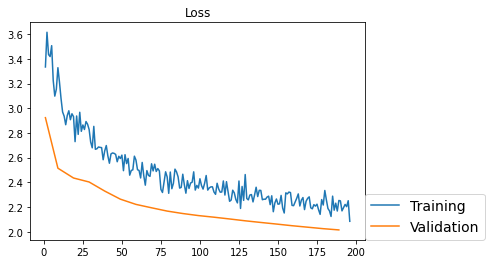

In [31]:
# Re-initialize weights
reset_parameters(model) 

# Train with defaul settings.
train_loss_history = fit(model)

**Note:** The validation loss (on the unseen data) is overall *lower* than the training loss. This might initially seem like an unexpected behaviour, but it results from the fact that we use 50% Dropout during training, meaning that half of the weights of the fully connected layers are not used during training. When evaluating the model on the validation set, Dropout is disabled, and all weights are used. This leads to a better prediction (i.e., a lower loss) on the validation set.

###3.7 Performing quick experiments on reduced dataset
When searching for hyperparameters it is often useful to perform quick experiments on only a small subset of the data. You can do this by decreasing the batch size and setting `batches_per_epoch` to say 20. The effective size of the training set is then `bs*batches_per_epoch` (say `128*20 = 2,560`), and the total number of batches being processed during training is `bs*batches_per_epoch*epochs` (say `128*20*5 = 51,200`).


Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.1480281 val loss 2.6242526 val accuracy 0.1015625
t 20 lr 0.001 train loss 2.9105659 val loss 2.502244 val accuracy 0.1109375
t 30 lr 0.001 train loss 2.6403248 val loss 2.4248629 val accuracy 0.1234375
t 40 lr 0.001 train loss 2.6025832 val loss 2.3029351 val accuracy 0.14687501
t 50 lr 0.001 train loss 2.5938673 val loss 2.2459328 val accuracy 0.1734375
t 60 lr 0.001 train loss 2.4766684 val loss 2.190738 val accuracy 0.1984375
t 70 lr 0.001 train loss 2.4878285 val loss 2.1539948 val accuracy 0.2125
t 80 lr 0.001 train loss 2.4773214 val loss 2.1220129 val accuracy 0.2125
t 90 lr 0.001 train loss 2.4265718 val loss 2.0898802 val accuracy 0.23281251
t 100 lr 0.001 train loss 2.2235165 val loss 2.0662043 val accuracy 0.2359375


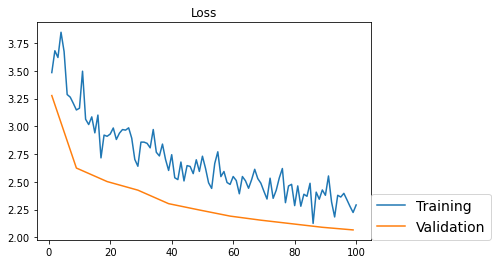

In [32]:
# Re-initialize weights
reset_parameters(model)

# Example: Train on small subset
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###3.7 Train with custom optimizer
Fell free to experiment with these optimizers.

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.1 train loss 2.1273618 val loss 2.108376 val accuracy 0.22500001
t 20 lr 0.1 train loss 2.002692 val loss 1.9879677 val accuracy 0.259375
t 30 lr 0.1 train loss 1.9825435 val loss 2.022526 val accuracy 0.2359375
t 40 lr 0.1 train loss 1.9502764 val loss 1.8936901 val accuracy 0.2875
t 50 lr 0.1 train loss 1.8012393 val loss 1.7828535 val accuracy 0.3609375
t 60 lr 0.1 train loss 1.7336177 val loss 1.759817 val accuracy 0.34375
t 70 lr 0.1 train loss 1.8243874 val loss 1.7069181 val accuracy 0.35
t 80 lr 0.1 train loss 1.7430257 val loss 1.6744179 val accuracy 0.37968752
t 90 lr 0.1 train loss 1.8371773 val loss 1.6625197 val accuracy 0.37968752
t 100 lr 0.1 train loss 1.6970863 val loss 1.8147649 val accuracy 0.30156252


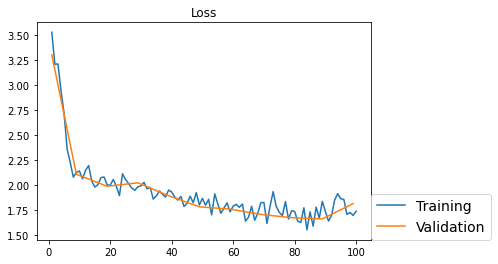

In [33]:
#SGD + Momentum
def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Adagrad
def adagrad_optimizer(model):
  return optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.0, weight_decay=0.0, initial_accumulator_value=0)

# RMSProp
def rmsprop_optimizer(model):
  return optim.RMSprop(model.parameters(), lr=0.1, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# Adam
def adam_optimizer(model):
  return optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Train with custom optimizer (on small subset)
reset_parameters(model) # Reset network weights
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

##4. Tasks: You are free to choose any of the tasks below
The overall goal is to make the model perform as good as possible on the CIFAR 10 dataset. Solving the tasks below might help you, but feel free to try other options. For inspiration, here is a list of other things, you could do:

- **Increase the capacity of the network** (add more conv layers, add more kernels in each layer, add another fully connected layer, add more connections in the fully connected layer, etc.)
- **Experiment with weight decay** (weight decay is an option for, say, the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD))

General recommendations for hyperparameter search (see Lecture 6 slides):
- Stage your search from course to fine
- Start with a small sample (subset) of the dataset to tune in on hyperparameters such as learning rate, and start with 1 epoch or less
- The second stage could then perform a narrower search with more data and/or more epochs
- Search for learning rates in powers of 10. Good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4, etc.)
- **Look at loss curves!!!**


###4.1 Implement a learning rate scheduler
**Your task** is to replace the function `base_lr_scheduler` with your own `step_decay` function (or another type of learning rate scheduler if you prefer). In step decay the lerning rate is updated for every `step` batches according to the rule `lr = lr * decay_rate`. The input `t` is the current batch index, ranging from 1 to `T`, where `T = batches_per_epoch * epochs` is the total number of batches.

**Solution:**

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.1 train loss 2.1947258 val loss 2.1377785 val accuracy 0.196875
t 20 lr 0.09000000000000001 train loss 2.003105 val loss 2.0384724 val accuracy 0.25468752
t 30 lr 0.08100000000000002 train loss 1.9845924 val loss 1.9189297 val accuracy 0.275
t 40 lr 0.07290000000000002 train loss 1.873486 val loss 2.065027 val accuracy 0.25468752
t 50 lr 0.06561000000000002 train loss 1.7943797 val loss 1.8697462 val accuracy 0.30937502
t 60 lr 0.05904900000000002 train loss 1.7813019 val loss 1.8073529 val accuracy 0.346875
t 70 lr 0.05314410000000002 train loss 1.7096221 val loss 1.802132 val accuracy 0.33281252
t 80 lr 0.04782969000000002 train loss 1.7538769 val loss 1.7547158 val accuracy 0.3609375
t 90 lr 0.043046721000000024 train loss 1.7743912 val loss 1.7726494 val accuracy 0.30937502
t 100 lr 0.03874204890000002 train loss 1.6815611 val loss 1.7122322 val accuracy 0.3546875


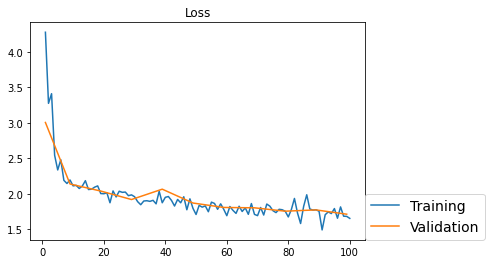

In [34]:
def step_decay(t,T,lr,step=10,decay_rate=0.9):
  if t % step == 0:
    lr = lr * decay_rate
  return lr

# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,opt_func=momentum_optimizer,lr_scheduler=step_decay,bs=128,epochs=5,batches_per_epoch=20)

**Sub-tasks:**
- What new hyperparameters are added with learning rate decay?
- See if you can make the model perform better with learning rate decay.

**Comment/answer:**
- Two more hyperparameters are added: `step` and `decay_rate`

###4.2 Implement a learning rate finder
Finding a good initial learning rate can be done efficiently with a learning rate finder. Here is the basic idea:

You can modify the learning rate scheduler `base_lr_scheduler` to use a hardcoded list of learning rates. This can be used to implement a learning rate finder according to this principle:
- Start training and increase learning rate linearly after each batch (!!!), and calculate the loss
- Then display the loss as a function of learning rate.
- By manual inspection, select a suitable range of learning rates by locating the strongest downward slope.

Say the hardcoded learning rates are:

In [35]:
# Ordered list of learning rates (ascending order)
lr_list = [0.001,0.01,0.05,0.1]

Then simply implement a learning rate scheduler that returns the t´th entry of the learning rate list:

In [36]:
def lr_finder(t,T,lr):
  return lr_list[t-1]

Note, the learning rate scheduler must have this interface: `(t,T,lr)`

Then train the model for as many batches as there are entries in the learning rate list:

In [37]:
# Make sure that we process as many batches as there are learning rates in our list:
batches_per_epoch = len(lr_list)
epochs = 1

# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)

Epochs: 1 Batches per epoch: 4 Total number of batches 4


Plot the loss versus learning rate and inspect:

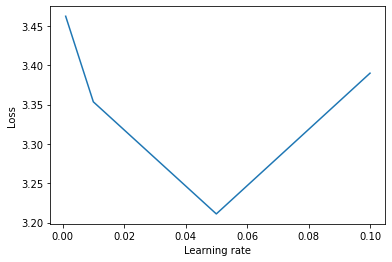

In [38]:
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xlabel('Learning rate');
plt.ylabel('Loss');

**Your task** is to implement a learning rate finder that searches through a range of learning rates, like above.

The range of learning rates should be logarithmic (say from 10^-6 to 10^0). You can define the list of learning rates using `np.logspace`.

Then plot the loss versus the learning rate. It is a good idea to use a logarithmic scale on the x-axis (see `plt.xscale('log')`).

####4.2.1 My solution

[1.00000000e-06 1.32571137e-06 1.75751062e-06 2.32995181e-06
 3.08884360e-06 4.09491506e-06 5.42867544e-06 7.19685673e-06
 9.54095476e-06 1.26485522e-05 1.67683294e-05 2.22299648e-05
 2.94705170e-05 3.90693994e-05 5.17947468e-05 6.86648845e-05
 9.10298178e-05 1.20679264e-04 1.59985872e-04 2.12095089e-04
 2.81176870e-04 3.72759372e-04 4.94171336e-04 6.55128557e-04
 8.68511374e-04 1.15139540e-03 1.52641797e-03 2.02358965e-03
 2.68269580e-03 3.55648031e-03 4.71486636e-03 6.25055193e-03
 8.28642773e-03 1.09854114e-02 1.45634848e-02 1.93069773e-02
 2.55954792e-02 3.39322177e-02 4.49843267e-02 5.96362332e-02
 7.90604321e-02 1.04811313e-01 1.38949549e-01 1.84206997e-01
 2.44205309e-01 3.23745754e-01 4.29193426e-01 5.68986603e-01
 7.54312006e-01 1.00000000e+00]
Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 9.540954763499944e-06 train loss 4.309731 val loss 3.0623999 val accuracy 0.08112981
t 20 lr 0.00015998587196060574 train loss 4.590661 val loss 3.1934628 val accuracy 0

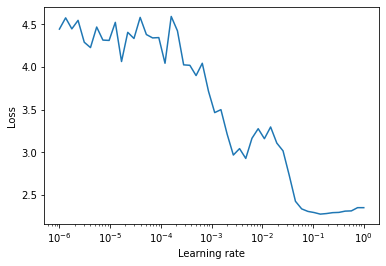

In [39]:
batches_per_epoch = 50
lr_list = np.logspace(-6,0,batches_per_epoch) # Your code goes here
print(lr_list)

# Run
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xscale('log') # Use log scale on x-axis
plt.xlabel('Learning rate');
plt.ylabel('Loss');

**Comments: What to look for?**
The numerical value of the loss is not important. What is important is the rate of change of the loss. So what we are looking for is the range of learning rates, where the loss decreases most rapidly. That seems to be somewhere between 10^-2 and 10^-1 (look for steepest slope).

**Additional sub-task:** Can you come up with a simple way to implement Cyclic Learning Rate (CLR) based on the above?

Hint: Run training multiple times using a carefully selected list of learning rates each time.

####4.2.2 My solution
Train 4 cycles, and in each cycle use 50 learning rates from 10^-2 to 10^-1.

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 2.2128267 val loss 2.2551506 val accuracy 0.17127405
t 20 lr 0.04291934260128778 train loss 2.106121 val loss 2.1287136 val accuracy 0.2469952
t 30 lr 0.02682695795279726 train loss 1.9807233 val loss 2.042036 val accuracy 0.2797476
t 40 lr 0.016768329368110083 train loss 1.9733783 val loss 1.9344919 val accuracy 0.2908654
t 50 lr 0.010481131341546858 train loss 1.903069 val loss 1.8987674 val accuracy 0.30859375


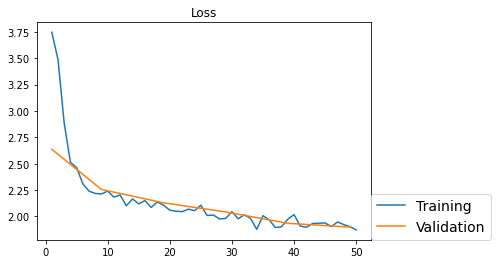

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.8949109 val loss 1.8802505 val accuracy 0.30048078
t 20 lr 0.04291934260128778 train loss 1.9114196 val loss 1.8209826 val accuracy 0.34284857
t 30 lr 0.02682695795279726 train loss 1.8354963 val loss 1.7716895 val accuracy 0.35126203
t 40 lr 0.016768329368110083 train loss 1.7306345 val loss 1.7494472 val accuracy 0.37469953
t 50 lr 0.010481131341546858 train loss 1.7016826 val loss 1.7229655 val accuracy 0.37229568


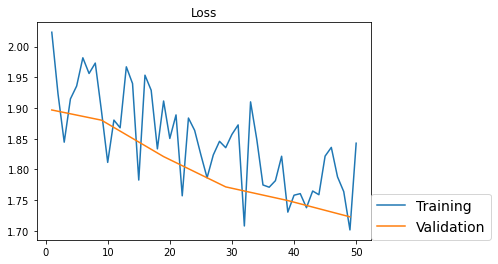

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.8309073 val loss 1.7002478 val accuracy 0.375
t 20 lr 0.04291934260128778 train loss 1.6704113 val loss 1.7036345 val accuracy 0.3771034
t 30 lr 0.02682695795279726 train loss 1.7294557 val loss 1.674924 val accuracy 0.39362982
t 40 lr 0.016768329368110083 train loss 1.7464832 val loss 1.643532 val accuracy 0.41015628
t 50 lr 0.010481131341546858 train loss 1.7498083 val loss 1.6350343 val accuracy 0.41316107


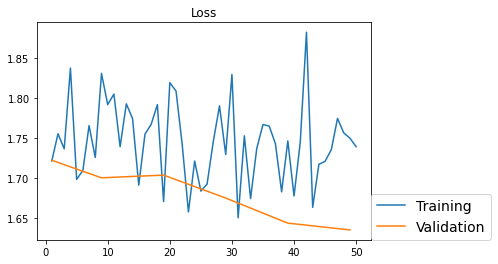

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.7827497 val loss 1.624191 val accuracy 0.40625003
t 20 lr 0.04291934260128778 train loss 1.6978518 val loss 1.6406597 val accuracy 0.40144232
t 30 lr 0.02682695795279726 train loss 1.7041715 val loss 1.6055884 val accuracy 0.4221755
t 40 lr 0.016768329368110083 train loss 1.6987536 val loss 1.5989172 val accuracy 0.42007214
t 50 lr 0.010481131341546858 train loss 1.5542476 val loss 1.5819349 val accuracy 0.42247596


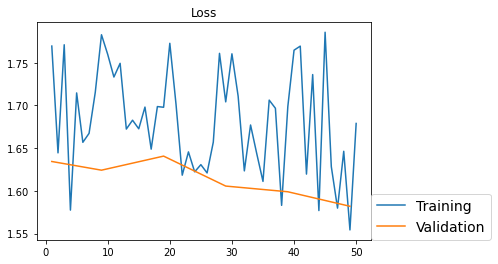

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.6251997 val loss 1.6000407 val accuracy 0.4161659
t 20 lr 0.04291934260128778 train loss 1.6145297 val loss 1.5946562 val accuracy 0.41496396
t 30 lr 0.02682695795279726 train loss 1.6825811 val loss 1.5657663 val accuracy 0.43479568
t 40 lr 0.016768329368110083 train loss 1.5645218 val loss 1.5705765 val accuracy 0.42247596
t 50 lr 0.010481131341546858 train loss 1.713465 val loss 1.5473516 val accuracy 0.4341947


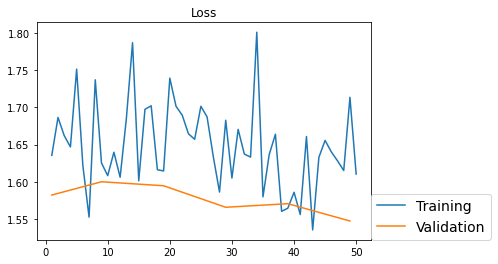

In [40]:
lr_list = np.logspace(-2,-1,50) # Learning rates in ascending order
lr_list = np.flip(lr_list,axis=0) # Learning rates in descending order
batches_per_epoch = len(lr_list)
epochs = 1

def CLR(t,T,lr):
  return lr_list[t-1]

reset_parameters(model)
for cycle in range(5):  
  train_loss_history = fit(model,lr_scheduler=CLR,epochs=epochs,batches_per_epoch=batches_per_epoch)

###4.3 Experiment with dropout
Below is a slight modification of our model that allows changing the dropout fraction (p).

**Your task** is to experiment with different values of p.

- What does setting p = 0 mean?
- Try different values of p (say 0, 0.1, 0.5 and 0.9). What is the optimal value of p?

In [41]:
def Net(p=0.5):
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=p),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

# Model with p=0.25
model = Net(p=0.25).cuda()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 2.624585 val loss 2.4577405 val accuracy 0.1265625
t 20 lr 0.001 train loss 2.4809709 val loss 2.3328214 val accuracy 0.15
t 30 lr 0.001 train loss 2.225812 val loss 2.2501996 val accuracy 0.1796875
t 40 lr 0.001 train loss 2.209397 val loss 2.1855805 val accuracy 0.2125
t 50 lr 0.001 train loss 2.1981585 val loss 2.1240704 val accuracy 0.23125
t 60 lr 0.001 train loss 2.0144353 val loss 2.0841327 val accuracy 0.2359375
t 70 lr 0.001 train loss 1.938862 val loss 2.0615106 val accuracy 0.24062501
t 80 lr 0.001 train loss 2.1287174 val loss 2.0287395 val accuracy 0.2515625
t 90 lr 0.001 train loss 1.9340383 val loss 2.0164673 val accuracy 0.259375
t 100 lr 0.001 train loss 1.939348 val loss 2.0002828 val accuracy 0.2578125


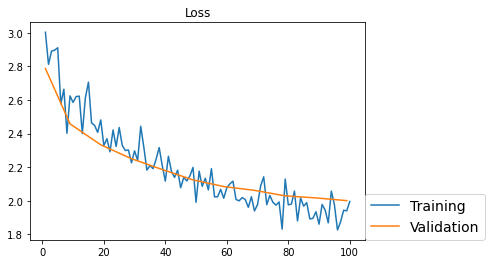

In [42]:
# p = 0 means no dropout
model = Net(p=0.0).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 5.769388 val loss 2.6255689 val accuracy 0.10625
t 20 lr 0.001 train loss 4.6107273 val loss 2.5996625 val accuracy 0.1
t 30 lr 0.001 train loss 4.372939 val loss 2.529756 val accuracy 0.109375
t 40 lr 0.001 train loss 3.8590536 val loss 2.394186 val accuracy 0.13125001
t 50 lr 0.001 train loss 3.7082405 val loss 2.3204286 val accuracy 0.1484375
t 60 lr 0.001 train loss 3.4263034 val loss 2.286295 val accuracy 0.1609375
t 70 lr 0.001 train loss 3.308602 val loss 2.2679315 val accuracy 0.15625
t 80 lr 0.001 train loss 3.1081307 val loss 2.254144 val accuracy 0.1578125
t 90 lr 0.001 train loss 3.0126615 val loss 2.2335136 val accuracy 0.1609375
t 100 lr 0.001 train loss 2.9794059 val loss 2.2191951 val accuracy 0.17812501


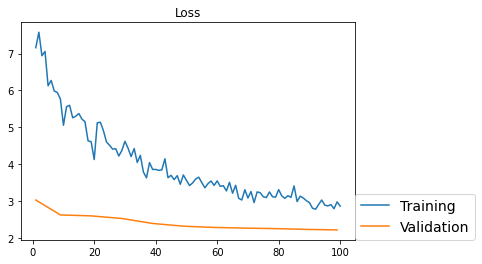

In [43]:
# p = 0.9 means "heavy dropout", which is in general a bad idea
model = Net(p=0.9).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 2.748964 val loss 2.4189367 val accuracy 0.11875
t 20 lr 0.001 train loss 2.554341 val loss 2.3632095 val accuracy 0.134375
t 30 lr 0.001 train loss 2.2526317 val loss 2.2979722 val accuracy 0.159375
t 40 lr 0.001 train loss 2.1366205 val loss 2.2424717 val accuracy 0.18125
t 50 lr 0.001 train loss 2.2380936 val loss 2.1877472 val accuracy 0.20937501
t 60 lr 0.001 train loss 2.118497 val loss 2.1465662 val accuracy 0.2453125
t 70 lr 0.001 train loss 2.0636888 val loss 2.116377 val accuracy 0.24843751
t 80 lr 0.001 train loss 2.0500085 val loss 2.0895631 val accuracy 0.2515625
t 90 lr 0.001 train loss 2.237238 val loss 2.0706022 val accuracy 0.259375
t 100 lr 0.001 train loss 1.9874687 val loss 2.038743 val accuracy 0.26250002


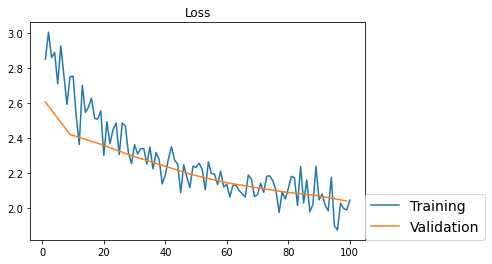

In [44]:
# p = 0.1
model = Net(p=0.1).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###4.4 Data augmentation
Adding more training data is the best way to improve your models abiliy to generalize to unseen data. Data augmentations is basically about generating additional *fake data" to expand the size of your training set.

**Your task** is to experiment with different types of data augmentation. All you have to do is change the transformer below and add some of the available transforms: https://pytorch.org/vision/stable/transforms.html

You can find inspiration in Lab 4: https://github.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2021/blob/main/Lab4_(part_3)_PyTorch_Transfer_Learning.ipynb


Files already downloaded and verified
Files already downloaded and verified
images.shape torch.Size([64, 3, 32, 32])


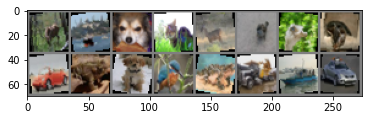

 deer  ship   dog   cat  deer  bird  bird   cat   car  frog   dog  bird  frog truck  ship   car


In [45]:
mean = 0.5
std = 0.5
transform = transforms.Compose(
    [ # My solution
      transforms.RandomHorizontalFlip(0.5), # Horizontally flip the given PIL Image randomly with a given probability. 
      transforms.ColorJitter(brightness=0.1), # Randomly change the brightness, contrast and saturation of an image
      transforms.RandomRotation(degrees=15), # Rotate the image by angle.
      transforms.ToTensor(),
      transforms.Normalize((mean, mean, mean), (std, std, std))
     ])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('images.shape',images.shape)

# show 10 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.3898277 val loss 2.7239785 val accuracy 0.104687504
t 20 lr 0.001 train loss 2.9229748 val loss 2.5445504 val accuracy 0.1140625
t 30 lr 0.001 train loss 2.9181645 val loss 2.4898918 val accuracy 0.109375
t 40 lr 0.001 train loss 2.7679188 val loss 2.4588876 val accuracy 0.120312504
t 50 lr 0.001 train loss 2.6515055 val loss 2.3751738 val accuracy 0.14375
t 60 lr 0.001 train loss 2.6662939 val loss 2.336078 val accuracy 0.1359375
t 70 lr 0.001 train loss 2.5108724 val loss 2.3140204 val accuracy 0.1578125
t 80 lr 0.001 train loss 2.580466 val loss 2.287544 val accuracy 0.16875
t 90 lr 0.001 train loss 2.3624015 val loss 2.2350147 val accuracy 0.171875
t 100 lr 0.001 train loss 2.3496525 val loss 2.2259796 val accuracy 0.175


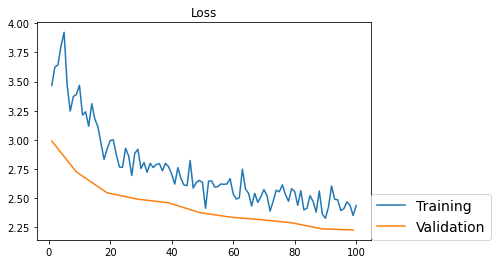

In [46]:
# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###4.5 Multi-task learning (MTL)
By sharing representations between related tasks, we can enable our model to generalize better on our original task. This is the basic idea behind MTL.

There is one additional task that we can always add, and that is an **autoencoder**. Recall that an autoencoder is basically an identity function that maps input x to itself. It does so by first encoding x into a more compact representation E(x), and then decodes this representation to get a reconstruction of x = D(E(x)), where E() is the encoder, and D() is the decoder.

The network below uses the **same encoder** to solve both a **classification task** and an **autoencoder task**.

In [47]:
# define the NN architecture
class MTLNet(nn.Module):
    def __init__(self):
        super(MTLNet, self).__init__()

        ## shared encoder layers ##
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 4, 5, stride=2, padding=2)
        
        ## decoder layers ##
        # Classifier
        self.fc1 = nn.Linear(in_features=4*8*8, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=10)

        ## Autoencoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # decoder for task 1 - outputs scores for classifier
        scores = x.view(-1, 4*8*8)
        scores = F.relu(self.fc1(scores))
        scores = self.fc2(scores)

        ## decoder for task 2 - outputs reconstruction of input x
        recon = F.relu(self.t_conv1(x))
        recon = self.t_conv2(recon)
                
        return scores, recon

# initialize the NN
model = MTLNet()

Let's look at the output of this model:

scores.shape torch.Size([64, 10])
recon.shape torch.Size([64, 3, 32, 32])

Input images:



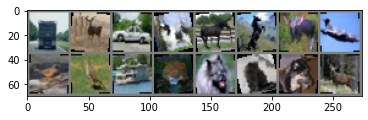

Reconstructed images:



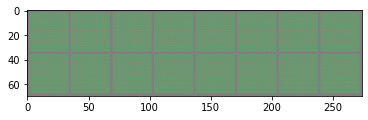

In [48]:
# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

scores,recon = model(images)
print('scores.shape',scores.shape)
print('recon.shape',recon.shape)

# show 16 images and print labels
print('\nInput images:\n')
imshow(torchvision.utils.make_grid(images[0:16]))
print('Reconstructed images:\n')
imshow(torchvision.utils.make_grid(recon[0:16].detach().cpu()))

In order to optimize our MTL model we need a loss function. However, since we are solving two tasks, we also need two terms in our loss function - one for each task.

The loss for the classification task is the familiar cross entropy:

In [49]:
# Classification loss
loss_func_1 = F.cross_entropy
loss1 = loss_func_1(scores, labels)
print('Loss 1', loss1)

Loss 1 tensor(2.3028, grad_fn=<NllLossBackward>)


A suitable loss for the autoencoder task would be the Mean Squared Error (MSE) between the input images (say `images`) and the networks reonstruction (say `recon`): 

In [50]:
# MSE loss for reconstruction
loss_func_2 = F.mse_loss
loss2 = loss_func_2(images,recon)
print('Loss 2', loss2)

Loss 2 tensor(0.3138, grad_fn=<MseLossBackward>)


Below is a modified function to fit the MTL model.

**Your task** is simply to fill in the missing code (marked with ???).

This is not as trivial as you might think (hint: do the two losses have the same scale?).

In [51]:
# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None,
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)
  
  loss1_history = []
  loss2_history = []
  plot_time_train = []
  
  # Initialize optimizer
  opt = opt_func(model)

  t = 1 # Index of current batch
  T = batches_per_epoch * epochs # Total number of batches
  
  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)
  
  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      scores,recon = model(xb.cuda())
      loss1 = loss_func_1(scores, yb.cuda())
      loss2 = loss_func_2(recon, xb.cuda())
      
      loss = loss1 + loss2

      if t % 10 == 0:    # print every 10 mini-batches
        print('loss1',loss1.detach().cpu().numpy(),'loss2',loss2.detach().cpu().numpy())

      loss1_history.append(loss1.detach().cpu().numpy())
      loss2_history.append(loss2.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,loss1_history)
    lines.append(l)
    labels.append('Loss1 (classification)')
    l, = plt.plot(plot_time_train,loss2_history)
    lines.append(l)
    labels.append('Loss2 (autoencoder)')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
loss1 2.2684298 loss2 0.33370242
loss1 2.2266874 loss2 0.28213784
loss1 2.2047486 loss2 0.2724884
loss1 2.0557399 loss2 0.2633099
loss1 2.1574147 loss2 0.2825651
loss1 1.9852284 loss2 0.28443503
loss1 1.9647508 loss2 0.2727613
loss1 1.9674001 loss2 0.28264531
loss1 1.930004 loss2 0.26105517
loss1 1.8553264 loss2 0.25808355


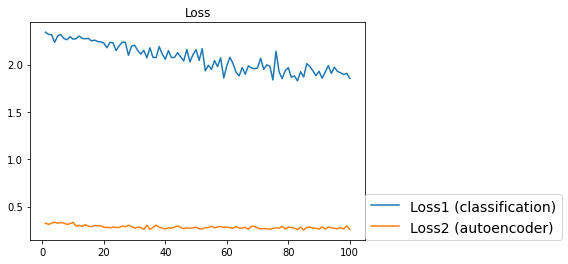

In [52]:
model = MTLNet().cuda()

# Re-initialize weights
reset_parameters(model)

def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Example (in practise you need more epochs than 5)
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

**Comments:**
- Here I set loss = loss1 + loss2, but clearly loss1 is much higher than loss2.
- To balance them out we could set loss = loss1 + 10*loss2:

In [53]:
# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None,
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)
  
  loss1_history = []
  loss2_history = []
  plot_time_train = []
  
  # Initialize optimizer
  opt = opt_func(model)

  t = 1 # Index of current batch
  T = batches_per_epoch * epochs # Total number of batches
  
  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)
  
  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      scores,recon = model(xb.cuda())
      loss1 = loss_func_1(scores, yb.cuda())
      loss2 = 10 * loss_func_2(recon, xb.cuda())
      
      loss = loss1 + loss2

      if t % 10 == 0:    # print every 10 mini-batches
        print('loss1',loss1.detach().cpu().numpy(),'loss2',loss2.detach().cpu().numpy())

      loss1_history.append(loss1.detach().cpu().numpy())
      loss2_history.append(loss2.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,loss1_history)
    lines.append(l)
    labels.append('Loss1 (classification)')
    l, = plt.plot(plot_time_train,loss2_history)
    lines.append(l)
    labels.append('Loss2 (autoencoder)')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

Epochs: 5 Batches per epoch: 20 Total number of batches 100
loss1 2.293619 loss2 2.7465785
loss1 2.2859793 loss2 2.9781222
loss1 2.20931 loss2 2.9957728
loss1 2.233472 loss2 2.7817557
loss1 2.0980113 loss2 2.5272298
loss1 2.1618655 loss2 1.925595
loss1 2.0927346 loss2 1.5295093
loss1 2.0921242 loss2 1.3355398
loss1 2.051772 loss2 1.1968476
loss1 1.9227092 loss2 1.171515


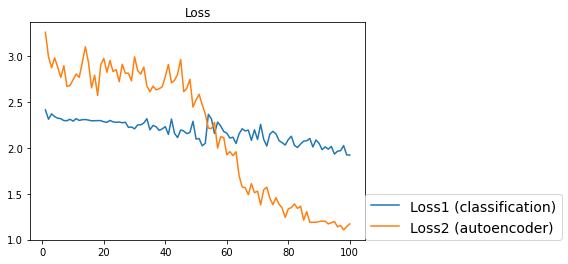

In [54]:
model = MTLNet().cuda()

# Re-initialize weights
reset_parameters(model)

def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Example (in practise you need more epochs than 5)
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

**Comment:** Looks better! Now, train for more epochs.

Epochs: 50 Batches per epoch: 20 Total number of batches 1000
loss1 1.99771 loss2 1.0743308
loss1 1.9675883 loss2 1.0627073
loss1 1.8321017 loss2 1.0433114
loss1 1.91827 loss2 1.0679231
loss1 1.7659917 loss2 1.0293832
loss1 1.7908955 loss2 0.9467399
loss1 1.9032447 loss2 0.9570601
loss1 1.5978494 loss2 0.8914277
loss1 1.7726797 loss2 0.9265475
loss1 1.822155 loss2 0.92653096
loss1 1.773521 loss2 0.9089544
loss1 1.8304133 loss2 0.80027604
loss1 1.74848 loss2 0.84863675
loss1 1.6681626 loss2 0.7985434
loss1 1.7732369 loss2 0.81970924
loss1 1.5458772 loss2 0.8302156
loss1 1.7675693 loss2 0.8338915
loss1 1.6436168 loss2 0.7497746
loss1 1.7622237 loss2 0.7129903
loss1 1.6825458 loss2 0.72663295
loss1 1.5147862 loss2 0.7152444
loss1 1.6894239 loss2 0.74525225
loss1 1.4999506 loss2 0.7564932
loss1 1.4499043 loss2 0.72080624
loss1 1.6141052 loss2 0.8150342
loss1 1.6034993 loss2 0.7403845
loss1 1.6880242 loss2 0.7524952
loss1 1.5564133 loss2 0.74954593
loss1 1.4537482 loss2 0.7121533
loss1 1.46

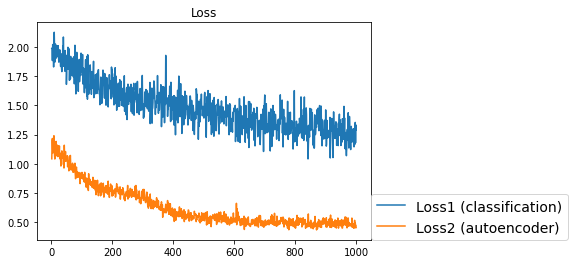

In [55]:
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=50,batches_per_epoch=20)

We should probably train for longer, but let's evaluate:

accuracy tensor(0.4182, device='cuda:0')

Input images:



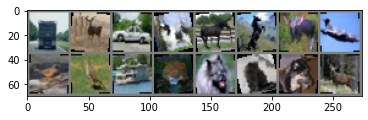

Reconstructed images:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


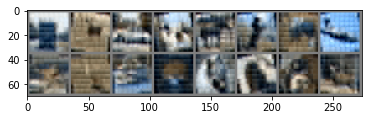

In [57]:
scores,recon = model(images.cuda())

# validation accuracy
acc = 0
for xb, yb in testloader:
  scores,recon_dummy = model(xb.cuda())
  acc += accuracy(scores,yb.cuda())
print('accuracy',acc/len(testloader))

# show 16 images and print labels
print('\nInput images:\n')
imshow(torchvision.utils.make_grid(images[0:16]))
print('Reconstructed images:\n')
imshow(torchvision.utils.make_grid(recon[0:16].detach().cpu()))